In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from kaggle_datasets import KaggleDatasets


2024-02-07 20:39:17.588102: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-07 20:39:17.588212: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-07 20:39:17.747164: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, Dropout, LeakyReLU, ReLU, ZeroPadding2D, GroupNormalization, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam



In [3]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

AUTOTUNE = tf.data.experimental.AUTOTUNE
AUTO = tf.data.experimental.AUTOTUNE    
print(tf.__version__)

Number of replicas: 1
2.15.0


In [4]:

# FP
sourcePath = KaggleDatasets().get_gcs_path()

monet_files= tf.io.gfile.glob(str(sourcePath + '/monet_tfrec/*.tfrec'))
photo_files= tf.io.gfile.glob(str(sourcePath + '/photo_tfrec/*.tfrec'))


print('No. of Monet TFRecord files: ',len(monet_files))
print('No. of Photo TFRecord files: ',len(photo_files))



No. of Monet TFRecord files:  5
No. of Photo TFRecord files:  20


In [5]:
# Image Size
IMAGE_SIZE = [256,256]

#function for decoding the image in jpg format
def decode_img(image):
    image = tf.image.decode_jpeg(image,channels=3)      #3 channels for RGB
    image = (tf.cast(image, tf.float32)/255)*2 - 1      #converting pixel vals in range [-1,1]
    image = tf.reshape(image, shape = [*IMAGE_SIZE,3])  #reshaping image to proper size
    return image

def read_tfrec(example):
    tfrec_format = {
        'image_name' : tf.io.FixedLenFeature([], tf.string), # [] denotes fixed len feature where len = 1
        'image': tf.io.FixedLenFeature([], tf.string),
        'target': tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example,tfrec_format)
    image = decode_img(example['image'])
    return image


In [6]:
def load_data(files):
    data = tf.data.TFRecordDataset(files)
    data = data.map(read_tfrec)
    return data

In [7]:
monet_data = load_data(monet_files).batch(1)
photo_data = load_data(photo_files).batch(1)

In [8]:
monet_data

<_BatchDataset element_spec=TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None)>

In [9]:
ex_monet = next(iter(monet_data))
ex_photo = next(iter(photo_data))

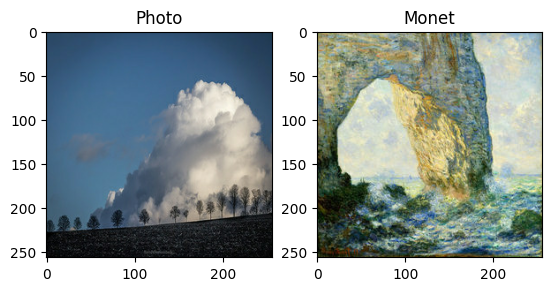

In [10]:
plt.subplot(1,2,1)                  # creating a subplot with 1 row and 2 cols
plt.title('Photo')
plt.imshow(ex_photo[0]*0.5 + 0.5)   # rescaling the img to [0,1] for displaying

plt.subplot(1,2,2)
plt.title('Monet')
plt.imshow(ex_monet[0]*0.5+0.5)

In [11]:
# Building the Generator

def downsample(filters, size, instance_norm = True):                # for extracting important features(size is reduced)
    initializer = tf.keras.initializers.GlorotNormal(seed=42)                
    gamma_init = keras.initializers.RandomNormal(mean = 0, stddev=0.02)

    model = keras.Sequential()
    model.add(Conv2D(
        filters, size, strides = 2, padding = 'same', kernel_initializer= initializer, use_bias = False))

    # groups =-1 to make it work like Instance Normalization
    if instance_norm:
        model.add(GroupNormalization(groups = -1,gamma_initializer = gamma_init)) 

    model.add(LeakyReLU())

    return model

In [12]:
#for locating features accurately using skip connections
def upsample(filters,size,dropout = False):
    initializer = tf.keras.initializers.GlorotNormal(seed=42)
    gamma_init= keras.initializers.RandomNormal(mean = 0, stddev = 0.02)

    model = keras.Sequential()
    model.add(Conv2DTranspose(
        filters, size,strides = 2, padding = 'same', kernel_initializer= initializer, use_bias = False))
    model.add(GroupNormalization(groups=-1, gamma_initializer = gamma_init))

    if dropout:
        model.add(Dropout(0.5))

    model.add(ReLU())

    return model


In [13]:
def generator():                            # size denotes the dims of image after the corresponding layer/op
    down_stack = [
        downsample(64,4,False),             # size = (128,128,64)
        downsample(128,4),                  # size = (64,64,128)
        downsample(256,4),                  # size = (32,32,256) 
        downsample(512,4),                  # size = (16,16,512)
        downsample(512,4),                  # size = (8,8,512)
        downsample(512,4),                  # size = (4,4,512)
        downsample(512,4),                  # size = (2,2,512)
        downsample(512,4),                  # size = (1,1,512)
    ]
    up_stack = [
        upsample(512,4,True),  # size = (2,2,1024) (num of channels doubled bc upsample block concats output of last downsample block)
        upsample(512,4,True),               # size = (4,4,1024)
        upsample(512,4,True),               # size = (8,8,1024)
        upsample(512,4),                    # size = (16,16,1024) dropout = false so info is maintained for gen detailed outputs
        upsample(256,4),                    # size = (32,32,512)
        upsample(128,4),                    # size = (64,64,256)
        upsample(64,4),                     # size = (128,128,128)
    ]

    initializer = tf.keras.initializers.GlorotUniform(seed=42)

    last_layer = Conv2DTranspose(       # 3 output channels is req
        3,4,strides = 2,padding= 'same', kernel_initializer = initializer, activation = 'tanh')
    
    i = Input(shape = [256,256,3])      # input layer
    x = i
    skips = []
    for down in down_stack:             # downsampling
        x = down(x)
        skips.append(x)                 # appending skip connections to the 'skips' list

    skips = reversed(skips[:-1])        # last skip connection is not used because of alignment with upsampling path
    
    for up, skip in zip(up_stack, skips):   #upsampling and concat output with skip connection
       
        #print("up:", up)
        #print("skip:", skip)
        x = up(x)
        x = Concatenate() ([x,skip])

    x = last_layer(x)                   # last layer (Conv2DTranspose) for generating the final output

    model = Model(i,x)

    return model#, len(up_stack), len(skips)

In [14]:
# Building the Discriminator

def discriminator():
    i = Input(shape = [256,256,3])
    x = downsample(64,4) (i)                # size = (128,128,64)
    x = downsample(128,4) (x)               # size = (64,64,128)
    x = downsample(256,4) (x)               # size = (32,32,256)

    x = ZeroPadding2D() (x)                 # size = (34,34,256) (1 pixel padding is added at top, bot, left, right)

    initializer = tf.keras.initializers.GlorotNormal(seed=42)
    gamma_init = keras.initializers.RandomNormal(mean=0, stddev=0.02)
    x = Conv2D(512, 4, strides = 1, padding = 'same', kernel_initializer = initializer, use_bias = False) (x) 
    # size = (31,31,512) (size = orig - kernel + 1)
    x = GroupNormalization(groups = -1, gamma_initializer = gamma_init) (x)
    x = LeakyReLU() (x)

    x = ZeroPadding2D() (x)                 # size = (33,33,512) zero padding applied to maintain spatial information

    x = Conv2D(1,4,strides=1, padding = 'same', kernel_initializer = initializer) (x) #size = (30,30,1)
    # sigmoid not used to output unbounded logitsN
    model = Model(i,x)                      # more numerically stable during training

    return model

In [15]:
# Initializing the generator & discriminator objects
monet_generator = generator()           # photo to monet-esque
monet_discriminator = discriminator()   # to differentiate between generated monet-esque images and real monet-esque images
photo_generator = generator()           # monet-esque to photo
photo_discriminator = discriminator()   # to differentiate between generated 'normal' images and real 'normal' images

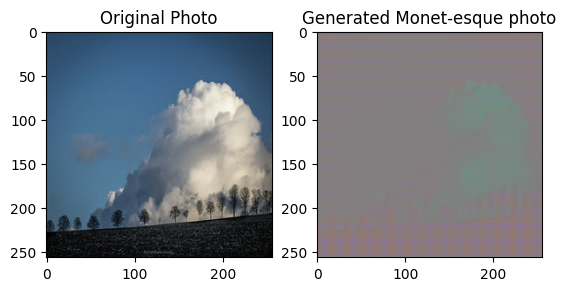

In [16]:
photo_to_monet = monet_generator(ex_photo)      # won't generate monet-esque photos as we have not fit hte data into generator yet

plt.subplot(1,2,1)                              # creating a subplot with 1 row and 2 cols
plt.title('Original Photo')
plt.imshow(ex_photo[0]*0.5 +0.5)                # rescaling the image to [0,1] for displaying

plt.subplot(1,2,2)
plt.title('Generated Monet-esque photo')
plt.imshow(photo_to_monet[0]*0.5 +0.5)

In [17]:
# Building the CycleGAN
class CycleGAN(keras.Model): # CycleGAN class inheriting from keras.MODEL class so that it can use its methods to train, compile, etc.
    def __init__(
            self,
            monet_gen,
            monet_disc,
            photo_gen,
            photo_disc,
            lambda_cycle = 3       # 'lambda_cycle' controls the importance of cycle consistency loss          
    ) :
        super(CycleGAN,self).__init__() # calls the constructor of the parent class(keras.Model)m initializing the base properties and methods
        self.m_gen = monet_gen
        self.m_disc = monet_disc
        self.p_gen = photo_gen
        self.p_disc = photo_disc
        self.lambda_cycle = lambda_cycle

    def compile(
            self,
            m_gen_optimizer,
            m_disc_optimizer,
            p_gen_optimizer,
            p_disc_optimizer,
            gen_loss_function,
            disc_loss_function,
            cycle_loss_function,
            identity_loss_function
    ) :
        super(CycleGAN,self).compile()             # calls the 'compile' fn of the parent class (keras.Model), initializing the base properties and methods
        self.m_gen_optimizer = m_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_function = gen_loss_function
        self.disc_loss_function = disc_loss_function
        self.cycle_loss_function = cycle_loss_function
        self.identity_loss_function = identity_loss_function

    def train_step(self, batch_data) :      # automatically invoked when fit() method is called 
        real_monet, real_photo = batch_data

        with tf.GradientTape(persistent= True) as tape:             # to keep a track of operations (persistent= True bcz of multiple calls to Gradient())
            
            fake_monet= self.m_gen(real_photo, training= True)      # photo to monet and then cycled back to photo
            cycled_photo= self.p_gen(fake_monet, training= True)
            
            fake_photo= self.p_gen(real_monet, training= True)      # monet to photo and then cycled back to monet
            cycled_monet= self.m_gen(fake_photo, training= True)
            
            same_photo= self.p_gen(real_photo, training= True)      # generating itself (useful in calculating identity loss)
            same_monet= self.m_gen(real_monet, training= True)      
            
            disc_real_photo= self.p_disc(real_photo, training= True)   # discriminator used to check by inputing real images
            disc_real_monet= self.m_disc(real_monet, training= True)   
            
            disc_fake_photo= self.p_disc(fake_photo, training= True)   # discriminator used to check by inputing fake images
            disc_fake_monet= self.m_disc(fake_monet, training= True)
            
            gen_monet_loss= self.gen_loss_function(disc_fake_monet)    # generator loss
            gen_photo_loss= self.gen_loss_function(disc_fake_photo)
            
            total_cycle_loss = (self.cycle_loss_function(real_monet, cycled_monet, self.lambda_cycle) +     # total cycle consistency loss
            self.cycle_loss_function(real_photo, cycled_photo, self.lambda_cycle))
            
            total_gen_monet_loss= (gen_monet_loss + total_cycle_loss   +                                    # total generator monet loss
            self.identity_loss_function(real_monet, same_monet, self.lambda_cycle) )  
            
            total_gen_photo_loss= (gen_photo_loss + total_cycle_loss   +                                    # total generator photo loss
            self.identity_loss_function(real_photo, same_photo, self.lambda_cycle) )
            
            disc_monet_loss= self.disc_loss_function(disc_real_monet, disc_fake_monet)                      # discriminator monet loss 
            disc_photo_loss= self.disc_loss_function(disc_real_photo, disc_fake_photo)                      # discriminator photo loss
            
            
        gen_monet_gradients= tape.gradient(total_gen_monet_loss, self.m_gen.trainable_variables)            # calculate gradients for generators
        gen_photo_gradients= tape.gradient(total_gen_photo_loss, self.p_gen.trainable_variables)            # diff loss fn wrt trainable variables of model
        
        disc_monet_gradients= tape.gradient(disc_monet_loss, self.m_disc.trainable_variables)               # calculate gradients for discriminators
        disc_photo_gradients= tape.gradient(disc_photo_loss, self.p_disc.trainable_variables)
        
        self.m_gen_optimizer.apply_gradients(zip(gen_monet_gradients, self.m_gen.trainable_variables))      # apply the gradients to optimizer
        self.p_gen_optimizer.apply_gradients(zip(gen_photo_gradients, self.p_gen.trainable_variables))      # basically performing gradient descent
        self.m_disc_optimizer.apply_gradients(zip(disc_monet_gradients, self.m_disc.trainable_variables))
        self.p_disc_optimizer.apply_gradients(zip(disc_photo_gradients, self.p_disc.trainable_variables))
        
        return {
            'gen_monet_loss': total_gen_monet_loss,
            'gen_photo_loss': total_gen_photo_loss,
            'disc_monet_loss': disc_monet_loss,
            'disc_photo_loss': disc_photo_loss
        }

In [18]:
# Loss Functions

def gen_loss_fn(generated): # from_logits=True used bcz disc return unbounded values & NONE redn used to return tensor of indiv losses bc those values are returned at each epoch
    return BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated),generated)

In [19]:
def disc_loss_fn(real,generated):
    loss_real = BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real),real)
    loss_fake = BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated)

    total_loss = (loss_real + loss_fake)/2

    return total_loss

In [20]:
def cycle_loss_fn(real, cycled, lambda_cycle):
    loss = tf.reduce_mean(tf.abs(real - cycled))

    return lambda_cycle*loss    # lambda controls the weight of cycle consistency loss in overall loss 

In [21]:
def identity_loss_fn(real,same,Lambda):         # LAMBDA has same use as in case of cycle consistency loss
    loss = tf.reduce_mean(tf.abs(real - same))

    return Lambda*loss*0.5                      # factor of '0.5' used for normalization purposes

In [22]:
# Optimizers
m_gen_opt = Adam(learning_rate=2e-4, beta_1=0.5)
m_disc_opt = Adam(learning_rate=2e-4, beta_1=0.5)

p_gen_opt = Adam(learning_rate=2e-4, beta_1=0.5)
p_disc_opt = Adam(learning_rate=2e-4, beta_1=0.5)

In [23]:
#compiling and training/fitting
# Define the EarlyStopping callback
#early_stopping = EarlyStopping(monitor='gen_monet_loss', patience=5, restore_best_weights=True)
cyclegan_model = CycleGAN(monet_generator, monet_discriminator, photo_generator, photo_discriminator, 10)
cyclegan_model.compile(m_gen_opt, m_disc_opt, p_gen_opt, p_disc_opt, gen_loss_fn, disc_loss_fn, cycle_loss_fn, identity_loss_fn)

In [24]:
cyclegan_model.fit(tf.data.Dataset.zip((monet_data, photo_data)), epochs=50)

Epoch 1/50


2024-02-07 20:40:45.671086: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape ingradient_tape/model/sequential_10/dropout_2/dropout_1/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1707338454.786526     125 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


300/300 [==============================] - 222s 469ms/step - gen_monet_loss: 4.9156 - gen_photo_loss: 5.0350 - disc_monet_loss: 0.6617 - disc_photo_loss: 0.6719
Epoch 2/50
300/300 [==============================] - 144s 478ms/step - gen_monet_loss: 3.4895 - gen_photo_loss: 3.5353 - disc_monet_loss: 0.6749 - disc_photo_loss: 0.6752
Epoch 3/50
300/300 [==============================] - 145s 482ms/step - gen_monet_loss: 3.2176 - gen_photo_loss: 3.2785 - disc_monet_loss: 0.6728 - disc_photo_loss: 0.6774
Epoch 4/50
300/300 [==============================] - 145s 483ms/step - gen_monet_loss: 3.0274 - gen_photo_loss: 3.1032 - disc_monet_loss: 0.6585 - disc_photo_loss: 0.6511
Epoch 5/50
300/300 [==============================] - 145s 483ms/step - gen_monet_loss: 2.9173 - gen_photo_loss: 2.9754 - disc_monet_loss: 0.6526 - disc_photo_loss: 0.6485
Epoch 6/50
300/300 [==============================] - 145s 482ms/step - gen_monet_loss: 2.9013 - gen_photo_loss: 3.0185 - disc_monet_loss: 0.6389 - dis

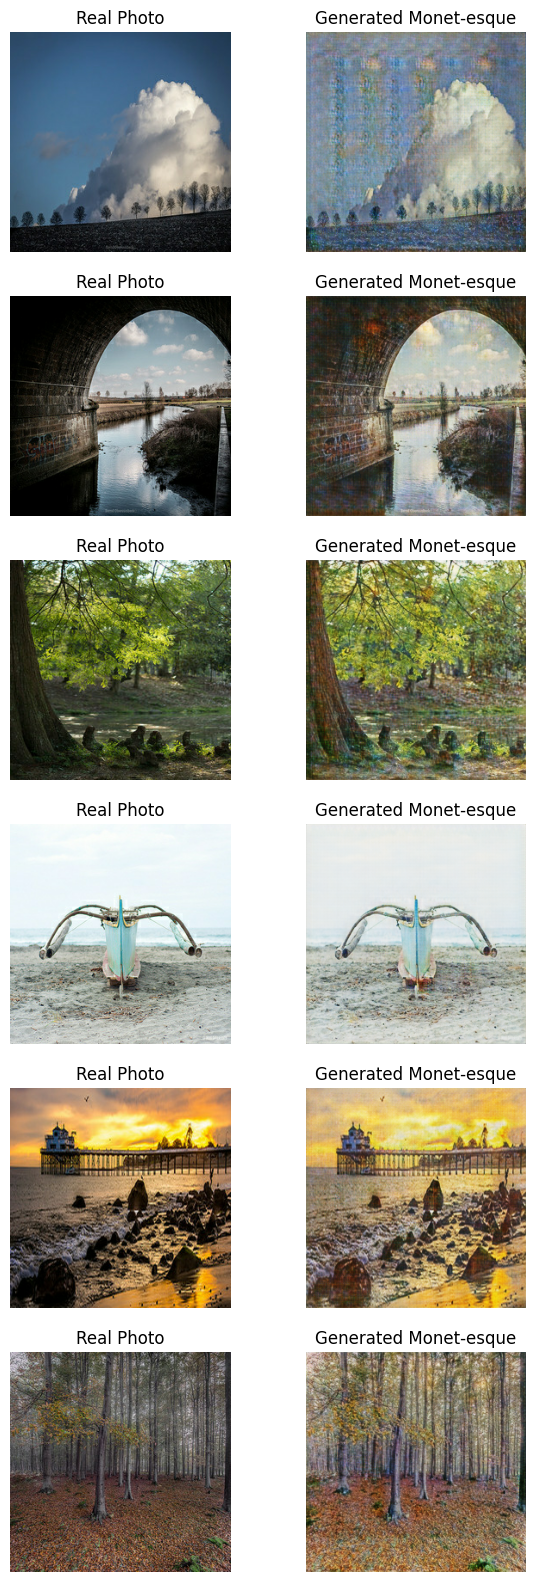

In [25]:
# Observing the output


fig,ax= plt.subplots(6,2, figsize=(7,20))
for i,img in enumerate(photo_data.take(6)):
    pred= monet_generator(img, training= False)[0].numpy()   # training= False to make sure not to update model's weights
    pred= (pred*127.5 + 127.5).astype(np.uint8)              # making pixel range to [0,255]
    img= (img[0]*127.5 + 127.5).numpy().astype(np.uint8)
    
    ax[i,0].imshow(img)
    ax[i,1].imshow(pred)
    ax[i,0].set_title('Real Photo')
    ax[i,1].set_title('Generated Monet-esque')
    ax[i,0].axis('off')
    ax[i,1].axis('off')



In [26]:
import PIL
import os

!mkdir kaggle/working/images


In [ ]:
i = 1
for image in photo_data:
    pred = monet_generator(image, training=False)[0].numpy()
    # Convert the prediction back to image format
    pred = (pred*127.5 + 127.5).astype(np.uint8)
    # Convert the numpy array to an image
    im = PIL.Image.fromarray(pred)
    im.save("../images/" + str(i) + ".jpg")
    i += 1

In [ ]:
import shutil
shutil.make_archive("/kaggle/working/images", 'zip', "/kaggle/images")